In [1]:
%pip install pennylane torch torchvision torchaudio scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 103.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import shutil
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, datasets, models
from PIL import Image

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.qnn import TorchLayer

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"
N_PER_CLASS = 2500
TOTAL_SAMPLES = N_PER_CLASS * 2
IMG_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 40
LR = 1e-3

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Device: cpu


In [4]:
import os
from pathlib import Path
from shutil import copy2
from glob import glob
import random
import shutil

SEED = 42
random.seed(SEED)
N_PER_CLASS = 2500
DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"

classes = ["Parasitized", "Uninfected"]
assert all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in classes), f"Check DATA_DIR and folder names. Expected subfolders: {classes}"

SUBSET_DIR = os.path.join(DATA_DIR, "Malaria_Subset_5000")
if os.path.exists(SUBSET_DIR):
    print("Subset dir exists — continuing with existing files.")
else:
    os.makedirs(SUBSET_DIR)
    print("Subset dir created.")

for c in classes:
    src_dir = os.path.join(DATA_DIR, c)
    dst_dir = os.path.join(SUBSET_DIR, c)
    os.makedirs(dst_dir, exist_ok=True)
    all_imgs = sorted(glob(os.path.join(src_dir, "*")))
    # Shuffle
    random.Random(SEED).shuffle(all_imgs)

    count = 0
    for p in all_imgs:
        fname = os.path.basename(p)
        # Skip hidden/system files
        if fname.startswith(".") or fname.endswith(".db"):
            continue
        copy2(p, dst_dir)
        count += 1
        if count >= N_PER_CLASS:
            break

print("Subset created at:", SUBSET_DIR)
print("Counts:")
for c in classes:
    print(c, len(glob(os.path.join(SUBSET_DIR, c, "*"))))

Subset dir created.
Subset created at: /content/drive/MyDrive/cell_images/cell_images/Malaria_Subset_5000
Counts:
Parasitized 2500
Uninfected 2500


In [5]:
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=None)
class_to_idx = full_dataset.class_to_idx
print("Class mapping:", class_to_idx)

# Split indices per class
indices_per_class = {cls_idx: [] for cls_idx in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(full_dataset.samples):
    indices_per_class[label].append(idx)

train_idx, val_idx, test_idx = [], [], []
for cls_idx, indices in indices_per_class.items():
    rng = random.Random(SEED)
    idxs = indices.copy()
    rng.shuffle(idxs)
    ncls_train = int(N_PER_CLASS * 0.70)
    ncls_val = int(N_PER_CLASS * 0.15)
    ncls_test = N_PER_CLASS - ncls_train - ncls_val
    train_idx.extend(idxs[:ncls_train])
    val_idx.extend(idxs[ncls_train:ncls_train + ncls_val])
    test_idx.extend(idxs[ncls_train + ncls_val: ncls_train + ncls_val + ncls_test])

# Create datasets and subsets
train_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)

print("Split sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Class mapping: {'Parasitized': 0, 'Uninfected': 1}
Split sizes: 3500 750 750


In [6]:
class SimpleCNNBackbone(nn.Module):
    def __init__(self, out_features=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, out_features, kernel_size=3, padding=1),  # output 4 channels
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        return x  # 4 features

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Feature correlation matrix:
 [[ 1.         -0.63106661 -0.23197149  0.08838614]
 [-0.63106661  1.         -0.0184009   0.71199207]
 [-0.23197149 -0.0184009   1.         -0.24380632]
 [ 0.08838614  0.71199207 -0.24380632  1.        ]]


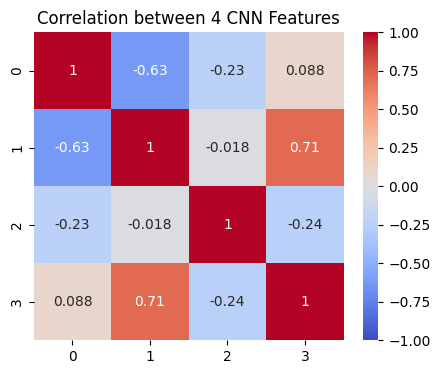

Features correlated → use entanglement and XY rotations


In [9]:
import seaborn as sns
images, _ = next(iter(train_loader))
images = images.to(DEVICE)

cnn_backbone = SimpleCNNBackbone(out_features=4).to(DEVICE)
cnn_backbone.eval()
with torch.no_grad():
    features = cnn_backbone(images).cpu().numpy()  # [batch_size, 4]

corr_matrix = np.corrcoef(features, rowvar=False)
print("Feature correlation matrix:\n", corr_matrix)

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between 4 CNN Features")
plt.show()

# Decide quantum circuit based on correlation
if np.max(np.abs(corr_matrix - np.eye(4))) > 0.3:  # if any off-diagonal > 0.3
    print("Features correlated → use entanglement and XY rotations")
    use_entanglement = True
    rotation_type = 'XY'
else:
    print("Features mostly independent → no entanglement, only Y rotations")
    use_entanglement = False
    rotation_type = 'Y'

In [16]:
n_qubits = 4
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    if rotation_type == 'XY':
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    else:
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    if use_entanglement:
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="backprop")
qlayer = TorchLayer(qnode, weight_shapes)

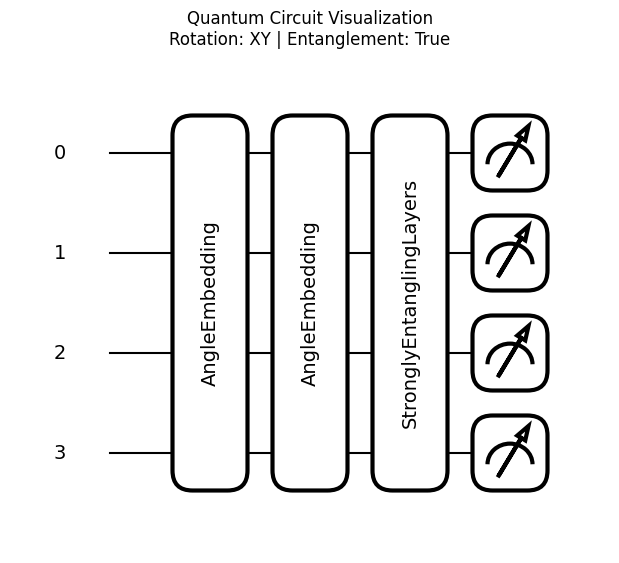

In [17]:
import matplotlib.pyplot as plt

# visualize circuit structure
dummy_input = torch.zeros(n_qubits)
dummy_weights = torch.zeros(weight_shapes["weights"])

fig, ax = qml.draw_mpl(quantum_circuit)(dummy_input, dummy_weights)
plt.title(f"Quantum Circuit Visualization\nRotation: {rotation_type} | Entanglement: {use_entanglement}")
plt.show()

In [22]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits=4, n_classes=NUM_CLASSES):
        super().__init__()
        self.backbone = SimpleCNNBackbone(out_features=n_qubits)
        self.qlayer = qlayer
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)
        )
    def forward(self, x):
        features = self.backbone(x)  # CNN → 4 features
        angles = torch.tanh(features) * np.pi
        q_out = self.qlayer(angles)
        out = self.classifier(q_out)
        return out

In [23]:
model = HybridModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
print(model)

HybridModel(
  (backbone): SimpleCNNBackbone(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
  (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [26]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

In [27]:
import time

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0
best_state = None

total_start = time.time()  # total training time start

for epoch in range(1, NUM_EPOCHS+1):
    epoch_start = time.time()  # epoch time start
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)

    # store tracking metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | "
          f"Epoch Time: {epoch_time:.2f}s")

    # Save best state based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

# Load best model after all epochs
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\n Loaded best model with Val Acc: {best_val_acc*100:.2f}%")

total_time = time.time() - total_start
print(f" Total Training Time: {total_time:.2f} seconds")

Epoch 1/40 | Train Acc: 70.86% | Val Acc: 73.20% | Epoch Time: 30.56s
Epoch 2/40 | Train Acc: 71.43% | Val Acc: 75.20% | Epoch Time: 30.62s
Epoch 3/40 | Train Acc: 74.40% | Val Acc: 70.93% | Epoch Time: 30.27s
Epoch 4/40 | Train Acc: 74.60% | Val Acc: 72.67% | Epoch Time: 30.72s
Epoch 5/40 | Train Acc: 75.03% | Val Acc: 75.60% | Epoch Time: 31.10s
Epoch 6/40 | Train Acc: 77.03% | Val Acc: 78.27% | Epoch Time: 30.38s
Epoch 7/40 | Train Acc: 76.43% | Val Acc: 76.40% | Epoch Time: 29.67s
Epoch 8/40 | Train Acc: 76.06% | Val Acc: 78.93% | Epoch Time: 29.62s
Epoch 9/40 | Train Acc: 78.86% | Val Acc: 78.00% | Epoch Time: 29.68s
Epoch 10/40 | Train Acc: 78.80% | Val Acc: 73.87% | Epoch Time: 30.04s
Epoch 11/40 | Train Acc: 80.11% | Val Acc: 83.07% | Epoch Time: 29.94s
Epoch 12/40 | Train Acc: 82.51% | Val Acc: 80.67% | Epoch Time: 30.00s
Epoch 13/40 | Train Acc: 82.60% | Val Acc: 86.80% | Epoch Time: 30.28s
Epoch 14/40 | Train Acc: 85.69% | Val Acc: 86.53% | Epoch Time: 29.77s
Epoch 15/40 | T

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Total Test Time: 4.3200 sec
Avg Inference Time: 0.005760 sec/image (173.61 FPS)
Accuracy: 93.47%  Precision: 0.9223  Recall: 0.9493  F1: 0.9356

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       375
           1       0.95      0.92      0.93       375

    accuracy                           0.93       750
   macro avg       0.94      0.93      0.93       750
weighted avg       0.94      0.93      0.93       750



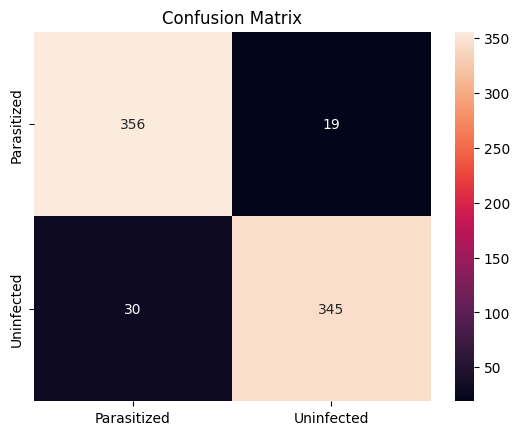

In [38]:
#Evaluate on test set
all_preds, all_labels = [], []
model.eval()

start_time = time.time()  # total inference time

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        t0 = time.time()
        outputs = model(imgs)
        batch_time = time.time() - t0
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

total_test_time = time.time() - start_time
avg_time = total_test_time / len(test_loader.dataset)

print(f"\nTotal Test Time: {total_test_time:.4f} sec")
print(f"Avg Inference Time: {avg_time:.6f} sec/image ({1/avg_time:.2f} FPS)")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='binary', pos_label=class_to_idx['Parasitized']
)

print(f"Accuracy: {acc*100:.2f}%  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=list(class_to_idx.keys()),
            yticklabels=list(class_to_idx.keys()))
plt.title("Confusion Matrix")
plt.show()

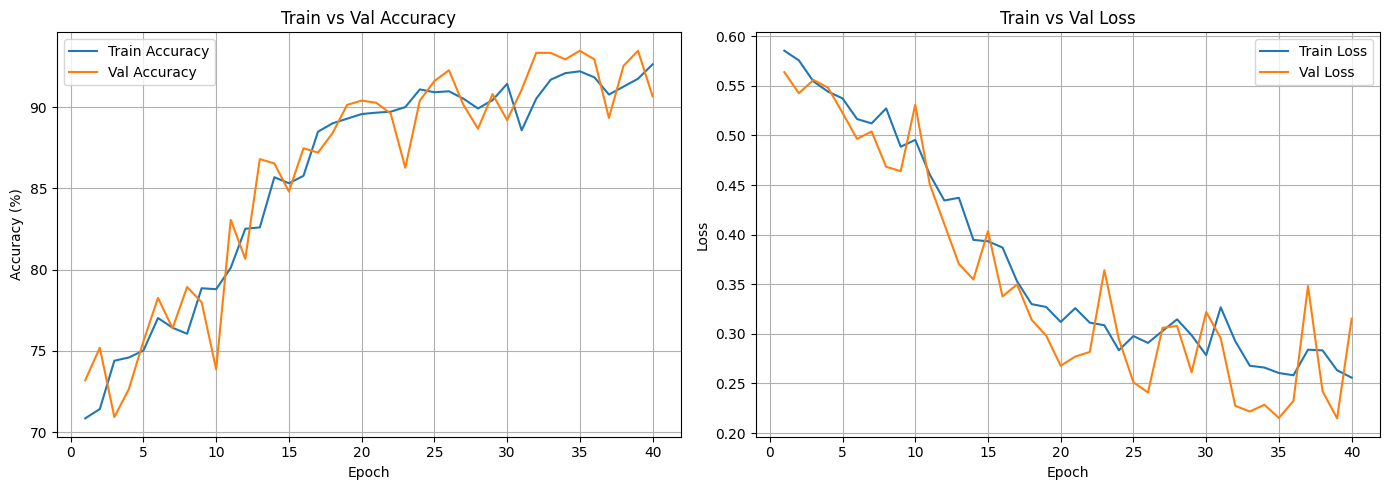

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# ------------------- Accuracy Plot -------------------
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in train_accs], label="Train Accuracy")
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in val_accs], label="Val Accuracy")
axs[0].set_title("Train vs Val Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

# ------------------- Loss Plot -------------------
axs[1].plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
axs[1].plot(range(1, NUM_EPOCHS+1), val_losses, label="Val Loss")
axs[1].set_title("Train vs Val Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()